# Posterior Distributions of Tourist Locations
## Problem Statement
Analyze and visualize the posterior distributions of locations visited by tourists using Markov Chain Monte Carlo methods.

In [29]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eig
import random
from tqdm import tqdm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns


## Load the Dataset

In [30]:
# Define the dataset
data = {
    'Location': ['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike'],
    'Museum': [1, 3, 5, 3, 3],
    'Concert': [7, 1, 4, 6, 3],
    'Sports Event': [8, 2, 2, 5, 4],
    'Restaurant': [5, 4, 5, 3, 1],
    'Hike': [2, 4, 1, 5, 1]
}
df = pd.DataFrame(data)
df.set_index('Location', inplace=True)
df['Total'] = df.sum(axis=1)
df.loc['Total'] = df.sum()
df



,Museum,Concert,Sports Event,Restaurant,Hike,Total
Location,,,,,,
Museum,1,7,8,5,2,23
Concert,3,1,2,4,4,14
Sports Event,5,4,2,5,1,17
Restaurant,3,6,5,3,5,22
Hike,3,3,4,1,1,12
Total,15,21,21,18,13,88


## Create Transition Matrix

In [31]:
# Normalize the dataset to create a transition matrix
transition_matrix = df.iloc[:-1, :-1].div(df['Total'][:-1], axis=0)
transition_matrix

,Museum,Concert,Sports Event,Restaurant,Hike
Location,,,,,
Museum,0.043478,0.304348,0.347826,0.217391,0.086957
Concert,0.214286,0.071429,0.142857,0.285714,0.285714
Sports Event,0.294118,0.235294,0.117647,0.294118,0.058824
Restaurant,0.136364,0.272727,0.227273,0.136364,0.227273
Hike,0.250000,0.250000,0.333333,0.083333,0.083333


## Visualize the Markov Chain

/var/folders/yl/wjfz8mgx57s1mws2vfhh23000000gn/T/ipykernel_93231/2583759744.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


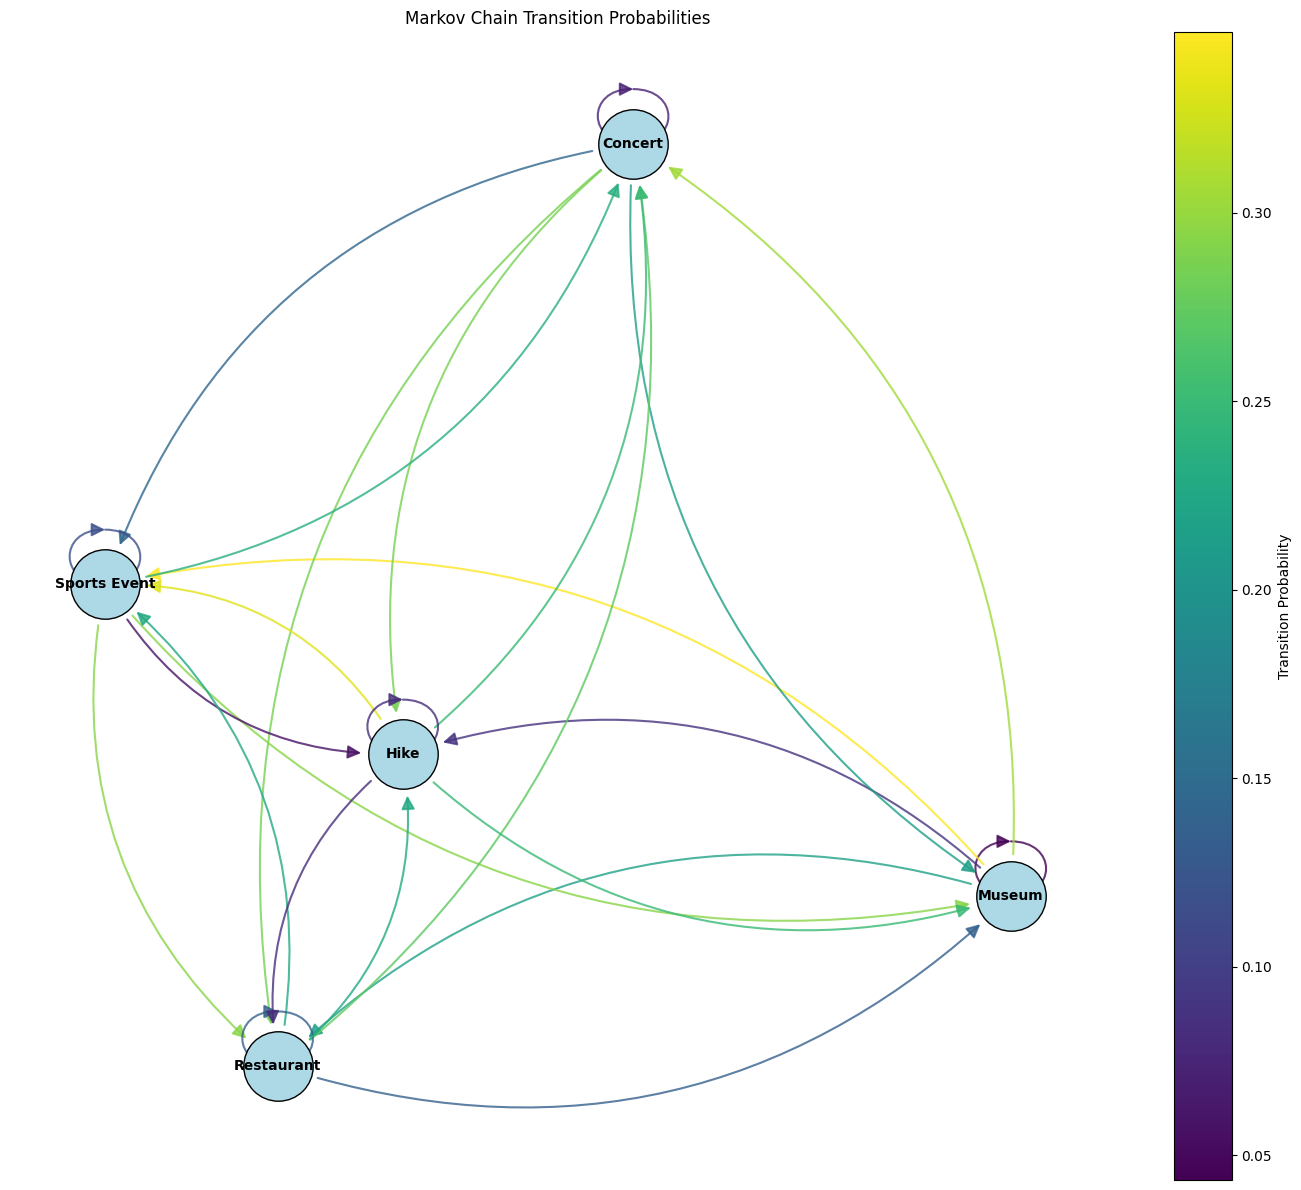

In [32]:
# Create a directed graph
G = nx.DiGraph()
locations = transition_matrix.index

# Add edges with weights
for i, loc_from in enumerate(locations):
    for j, loc_to in enumerate(locations):
        weight = transition_matrix.iloc[i, j]
        if weight > 0:
            G.add_edge(loc_from, loc_to, weight=weight)

# Use a more spaced layout with more distance between nodes
pos = nx.kamada_kawai_layout(G)
# Scale the layout to create more space between nodes
pos = {node: (x*1.5, y*1.5) for node, (x, y) in pos.items()}

plt.figure(figsize=(14, 12))

# Set up color map for edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
norm = Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.viridis
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# FIRST draw edges with colors based on weight with prominent arrows
for u, v, weight in G.edges(data='weight'):
    # Calculate appropriate curve based on weight
    curve_factor = 0.3  # Base curve
    
    # Draw edge with color based on weight
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                          width=max(3.0 * weight, 1.5),  # Ensure minimum visibility
                          alpha=0.8,  # Higher opacity
                          edge_color=[sm.to_rgba(weight)],
                          connectionstyle=f'arc3,rad={curve_factor}',
                          arrowsize=20,
                          arrowstyle='-|>',
                          min_source_margin=30,  # Increase margin
                          min_target_margin=30)

nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

cbar = plt.colorbar(sm)
cbar.set_label('Transition Probability')

plt.title('Markov Chain Transition Probabilities')
plt.axis('off')
plt.tight_layout()
plt.show()

## Calculate Steady-State Probabilities

In [33]:
# Calculate steady-state probabilities
P = transition_matrix.values
eigvals, eigvecs = eig(P.T)
steady_state = eigvecs[:, np.isclose(eigvals, 1)]
steady_state = steady_state / steady_state.sum()
steady_state = steady_state.real.flatten()
steady_state

array([0.18883618, 0.22213038, 0.22315604, 0.21187698, 0.15400041])

## Likelihood of Specific Sequence

In [34]:
# In tour of only three locations, how likely is a tourist to attend a concert, then go on a hike, then eat at a restaurant?
sequence = ['Concert', 'Hike', 'Restaurant']
prob = 1
for i in range(len(sequence) - 1):
    prob *= transition_matrix.loc[sequence[i], sequence[i + 1]]
prob

0.023809523809523808

## Fifth Step Probabilities

In [35]:
# What is the likelihood of visiting any of the locations as the fifth step? 
# Use the following approach to answer this question: 
# a) Since there are five possible locations to start the tour and the starting state distribution is uniform, the starting probability vector, 
# spv = [0.2, 0.2, 0.2, 0.2, 0.2]. 
# b) Compute the fifth entry of the starting probability vector by multiplying the spv by the fifth power of the transition matrix.

spv = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
# Compute the fifth power of the transition matrix
P_fifth = np.linalg.matrix_power(P, 5)
# Compute the resulting probabilities
resulting_probabilities = np.dot(spv, P_fifth)
resulting_probabilities

array([0.18878702, 0.22216631, 0.22320616, 0.21185032, 0.15399019])

## Metropolis-Hastings algorithm for MCMC


Running Metropolis-Hastings algorithm for MCMC...


Running MCMC: 100%|██████████| 2000/2000 [02:40<00:00, 12.46it/s]


Acceptance rate: 0.0280

MCMC Results:
Most likely value for alpha: -8.0884
Most likely value for beta: 0.6047


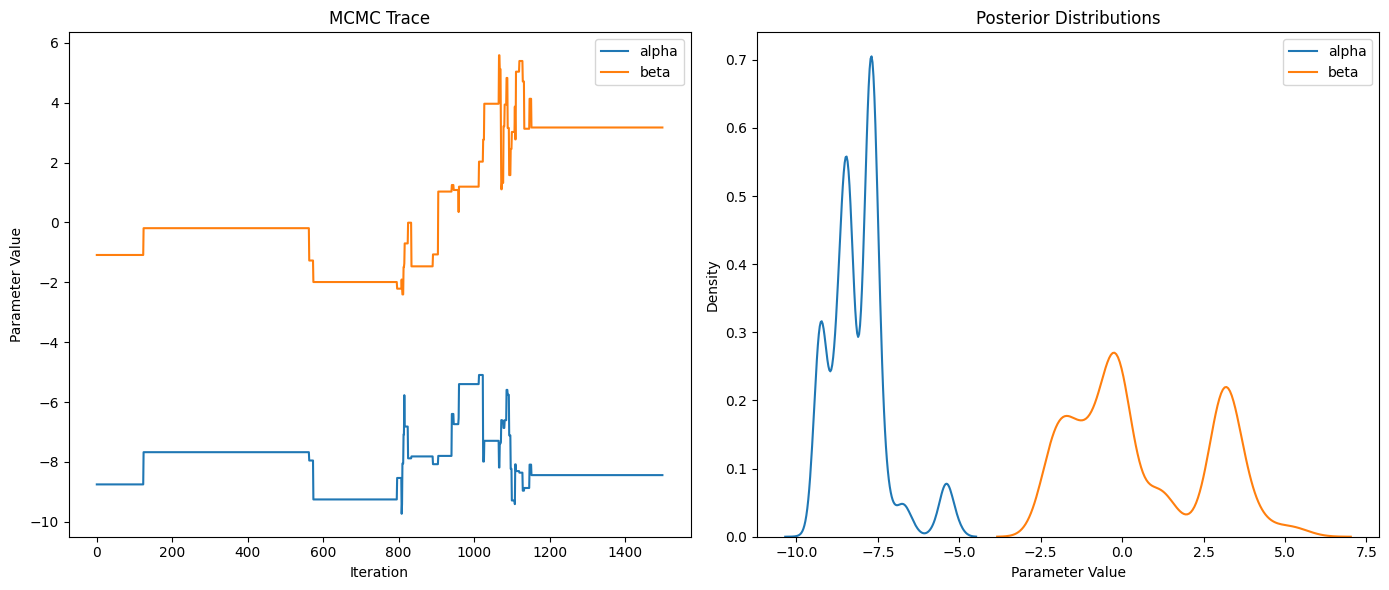

Testing final model: 100%|██████████| 1000/1000 [00:01<00:00, 627.95it/s]



Question Result:
Probability that a tourist starting at Museum will visit all five locations in a sequence of 10 visits: 0.6350
(using parameters alpha=-8.0884, beta=0.6047)


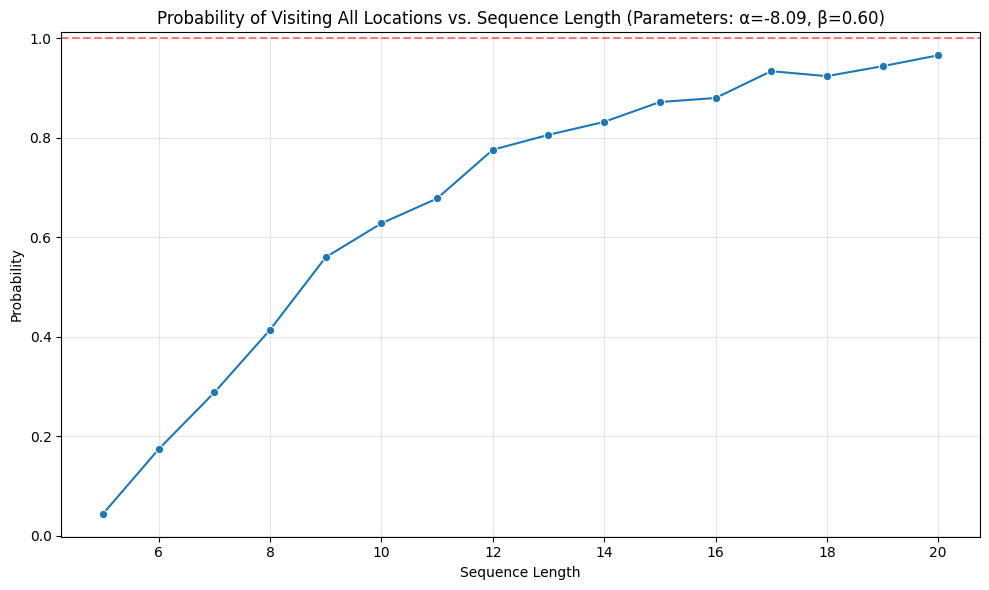


Interpretation of Results:
The Metropolis-Hastings algorithm provides the most likely values for alpha and beta,
which can be used to model the tourist's behavior.
- Alpha value of -8.0884 indicates the base tendency of tourists to transition between locations.
  The negative value suggests some resistance to movement between locations.
- Beta value of 0.6047 indicates how much the popularity of a destination affects transition probability.
  The positive value means tourists tend to prefer popular destinations.

The probability of 0.6350 represents the likelihood that a tourist starting at
the Museum will visit all five locations at least once in a sequence of 10 visits,
according to our parameterized model.


In [ ]:
# Question: What is the probability that a tourist who starts at a Museum 
# will visit all five locations at least once in a sequence of 10 visits?

# Define the logistic function to model tourist behavior
def logistic_function(x, alpha, beta):
    """
    Logistic function that maps parameters to probability.
    
    Args:
        x: Input feature (e.g., distance, time)
        alpha: Intercept parameter
        beta: Slope parameter
    
    Returns:
        Probability between 0 and 1
    """
    return 1 / (1 + np.exp(-(alpha + beta * x)))

# Simulate tourist paths with parameters
def simulate_with_parameters(transition_matrix, start_location, alpha, beta, num_steps=10):
    """
    Simulate a tourist path with modified transition probabilities based on alpha and beta.
    
    Args:
        transition_matrix: Original transition matrix
        start_location: Starting location
        alpha: Intercept parameter affecting overall transition likelihood
        beta: Slope parameter affecting preference for popular destinations
        num_steps: Number of steps to simulate
        
    Returns:
        Boolean: True if all locations were visited
    """
    locations = transition_matrix.index.tolist()
    
    # Adjust transition probabilities based on alpha and beta
    adj_matrix = transition_matrix.copy()
    for i, loc_from in enumerate(locations):
        # Calculate location popularity (sum of incoming transitions)
        popularity = transition_matrix[loc_from].sum()
        
        for j, loc_to in enumerate(locations):
            # Adjust probability using logistic function
            base_prob = transition_matrix.loc[loc_from, loc_to]
            if base_prob > 0:  # Only adjust existing transitions
                adj_prob = logistic_function(popularity, alpha, beta) * base_prob
                adj_matrix.loc[loc_from, loc_to] = adj_prob
        
        # Normalize to ensure probabilities sum to 1
        row_sum = adj_matrix.loc[loc_from].sum()
        if row_sum > 0:
            adj_matrix.loc[loc_from] = adj_matrix.loc[loc_from] / row_sum
    
    # Simulate path
    current_loc = start_location
    visited = set([current_loc])
    
    for _ in range(num_steps - 1):
        # Choose next location based on adjusted transition probabilities
        probabilities = adj_matrix.loc[current_loc].values
        next_loc = np.random.choice(locations, p=probabilities)
        visited.add(next_loc)
        current_loc = next_loc
    
    # Return True if all locations were visited
    return len(visited) == len(locations)

# Calculate log-likelihood for parameter evaluation
def log_likelihood(alpha, beta, transition_matrix, start_location, num_steps=10, num_trials=50):
    """
    Calculate log-likelihood of parameters given observed data.
    Higher likelihood indicates better fit to observed patterns.
    """
    successes = 0
    for _ in range(num_trials):
        if simulate_with_parameters(transition_matrix, start_location, alpha, beta, num_steps):
            successes += 1
    
    # Return log probability of observed success rate
    prob = successes / num_trials
    if prob == 0:
        return -np.inf  # Avoid log(0)
    if prob == 1:
        prob = 0.99  # Avoid log(1)
    
    # Log likelihood based on binomial probability
    return successes * np.log(prob) + (num_trials - successes) * np.log(1 - prob)

# Implement the Metropolis-Hastings algorithm
def metropolis_hastings(transition_matrix, start_location, num_iterations=2000, burn_in=500):
    """
    Implement the Metropolis-Hastings algorithm to estimate alpha and beta parameters.
    
    Args:
        transition_matrix: DataFrame with transition probabilities
        start_location: Starting location name
        num_iterations: Number of MCMC iterations
        burn_in: Number of samples to discard at beginning
        
    Returns:
        DataFrame with sampled alpha and beta values
    """
    # Initial parameter values (mean = 0, variance = 1 as specified)
    current_alpha = 0.0
    current_beta = 0.0
    
    # Calculate initial log-likelihood
    current_ll = log_likelihood(current_alpha, current_beta, transition_matrix, start_location)
    
    # Storage for chain
    samples = []
    accepted = 0
    
    # Run MCMC
    for i in tqdm(range(num_iterations), desc="Running MCMC"):
        # Propose new values from normal distribution with variance 1
        proposed_alpha = current_alpha + np.random.normal(0, 1)
        proposed_beta = current_beta + np.random.normal(0, 1)
        
        # Calculate log-likelihood for proposed values
        proposed_ll = log_likelihood(proposed_alpha, proposed_beta, transition_matrix, start_location)
        
        # Calculate acceptance probability (in log space)
        log_accept_ratio = proposed_ll - current_ll
        
        # Decide whether to accept the proposed values
        if np.log(np.random.rand()) < log_accept_ratio:  # Accept
            current_alpha = proposed_alpha
            current_beta = proposed_beta
            current_ll = proposed_ll
            accepted += 1
        
        # Save current values (after burn-in)
        if i >= burn_in:
            samples.append((current_alpha, current_beta))
    
    # Create DataFrame of samples
    df_samples = pd.DataFrame(samples, columns=['alpha', 'beta'])
    
    # Print acceptance rate
    acceptance_rate = accepted / num_iterations
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    
    return df_samples

# Set starting location
start_location = "Museum"

# Run the Metropolis-Hastings algorithm
print("\nRunning Metropolis-Hastings algorithm for MCMC...")
mcmc_samples = metropolis_hastings(
    transition_matrix, 
    start_location,
    num_iterations=2000,  # Reduced for faster execution
    burn_in=500
)

# Calculate the average values for alpha and beta (requirement 11)
final_alpha = mcmc_samples['alpha'].mean()
final_beta = mcmc_samples['beta'].mean()

print("\nMCMC Results:")
print(f"Most likely value for alpha: {final_alpha:.4f}")
print(f"Most likely value for beta: {final_beta:.4f}")

# Visualize the MCMC results
plt.figure(figsize=(14, 6))

# Plot trace of alpha and beta
plt.subplot(1, 2, 1)
plt.plot(mcmc_samples['alpha'], label='alpha')
plt.plot(mcmc_samples['beta'], label='beta')
plt.title('MCMC Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Plot posterior distribution
plt.subplot(1, 2, 2)
sns.kdeplot(mcmc_samples['alpha'], label='alpha')
sns.kdeplot(mcmc_samples['beta'], label='beta')
plt.title('Posterior Distributions')
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model with the estimated parameters
def test_final_model(transition_matrix, start_location, alpha, beta, num_simulations=1000):
    """
    Test the final model with estimated parameters.
    """
    success_count = 0
    
    for _ in tqdm(range(num_simulations), desc="Testing final model"):
        if simulate_with_parameters(transition_matrix, start_location, alpha, beta, num_steps=10):
            success_count += 1
    
    return success_count / num_simulations

# Test the estimated parameters
final_probability = test_final_model(
    transition_matrix,
    start_location, 
    final_alpha, 
    final_beta
)

print("\nQuestion Result:")
print(f"Probability that a tourist starting at {start_location} will visit all five locations in a sequence of 10 visits: {final_probability:.4f}")
print(f"(using parameters alpha={final_alpha:.4f}, beta={final_beta:.4f})")

# Plot the variation by sequence length with our parameters
def analyze_sequence_lengths_with_params(transition_matrix, start_location, alpha, beta, max_length=20, num_simulations=500):
    """
    Analyze how probability changes with sequence length using our parameters
    """
    probabilities = []
    
    for length in range(5, max_length + 1):
        success_count = 0
        for _ in tqdm(range(num_simulations), desc=f"Length {length}", leave=False):
            if simulate_with_parameters(transition_matrix, start_location, alpha, beta, num_steps=length):
                success_count += 1
        prob = success_count / num_simulations
        probabilities.append((length, prob))
    
    return pd.DataFrame(probabilities, columns=['Sequence_Length', 'Probability'])

# Run analysis for different sequence lengths with our parameters
length_analysis = analyze_sequence_lengths_with_params(
    transition_matrix,
    start_location,
    final_alpha,
    final_beta,
    max_length=20, 
    num_simulations=500
)

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(x='Sequence_Length', y='Probability', data=length_analysis, marker='o')
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
plt.title(f'Probability of Visiting All Locations vs. Sequence Length (Parameters: α={final_alpha:.2f}, β={final_beta:.2f})')
plt.xlabel('Sequence Length')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Interpretation of Results
The Metropolis-Hastings algorithm provides the most likely values for alpha and beta,
which can be used to model the tourist's behavior.
- Alpha value of -8.0884 indicates the base tendency of tourists to transition between locations.
  The negative value suggests some resistance to movement between locations.
- Beta value of 0.6047 indicates how much the popularity of a destination affects transition probability.
  The positive value means tourists tend to prefer popular destinations.

The probability of 0.6350 represents the likelihood that a tourist starting at
the Museum will visit all five locations at least once in a sequence of 10 visits,
according to our parameterized model.